In [2]:
import torch 
from torch.autograd import Variable
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval
import warnings 
import math

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
torch.manual_seed(43)

In [3]:
# training_set = pd.read_csv('../CSV_files/BALL/dataBall_SIFT.csv')
training_set = pd.read_csv('../CSV_files/BALL/dataBall_deepFeatures.csv')
dataSet_len = len(training_set)
print(f"number of frames: {dataSet_len}")
featuresAreCoordinates = False # When False displacement is used as input features
filteredInputs = False
training_set.describe()

number of frames: 98


,scale ratio,volume cm3
count,98.000000,98.000000
mean,0.515000,1070.837938
std,0.284341,1192.321784
min,0.030000,0.074059
25%,0.272500,83.044976
50%,0.515000,564.172160
75%,0.757500,1790.161047
max,1.000000,4122.998900


In [4]:
distance_sensorData = training_set['sensors_e']
x_sensorData = training_set['sensors_x']
y_sensorData = training_set['sensors_y']

In [7]:
def detect_outlier(data_1):
    outliers = []
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [8]:
# filter pre-calculated euclidean distance
filtered_distance = []
filtered_X_distance = []
filtered_Y_distance = []

max_distance = 40
max_Y_distance = 4
max_X_distance = 4

for i in range(len(distance_sensorData)):
    outliers_x, outliers_y, outliers_d = [], [], []
    max_distance *= 1.03
    distance_avg = 0
    distance_list = literal_eval(distance_sensorData[i])
    outliers_d = detect_outlier(distance_list)
    distance_list = [x for x in distance_list if x not in outliers_d if x < max_distance]
    if len(distance_list) > 0:
        distance_avg = sum(distance_list) / len(distance_list)
    filtered_distance.append(distance_avg)

    max_X_distance *= 1.03
    X_distance = 0
    X_list = literal_eval(x_sensorData[i])
    outliers_x = detect_outlier(X_list)
    X_list = [x for x in X_list if x not in outliers_x if x < max_X_distance  if x !=0]
    if len(X_list) > 0:
        X_distance = sum(X_list) / len(X_list)
    filtered_X_distance.append(X_distance)

    max_Y_distance *= 1.03
    Y_distance = 0
    Y_list = literal_eval(y_sensorData[i])
    outliers_y = detect_outlier(Y_list)
    Y_list = [x for x in Y_list if x not in outliers_y if x < max_Y_distance  if x !=0]
    if len(Y_list) > 0:
        Y_distance = sum(Y_list) / len(Y_list)
    filtered_Y_distance.append(Y_distance)

In [9]:
distance_sensorData = [literal_eval(i) for i in training_set['sensors_e']]
x_sensorData = [literal_eval(i) for i in training_set['sensors_x']]
y_sensorData = [literal_eval(i) for i in training_set['sensors_y']]
if featuresAreCoordinates:
    coordinates = [literal_eval(i) for i in training_set['coordinates_src']]
    coordinatesDST = [literal_eval(i) for i in training_set['coordinates_dst']]
    for i in range(len(coordinates)):
        coordinates[i].extend(coordinatesDST[i])

In [10]:
numberOfSensorsList = [len(i) for i in distance_sensorData]
meanOfSensors = sum(numberOfSensorsList)//len(numberOfSensorsList)
maxNumberSensors = max(numberOfSensorsList)
minNumberSensors = min(numberOfSensorsList)

print(f"max amount of sensors: {maxNumberSensors}")
print(f"min amount of sensors: {minNumberSensors}")
print(f"mean amount of sensors: {meanOfSensors}")

max amount of sensors: 98
min amount of sensors: 51
mean amount of sensors: 56


In [11]:
def standarizeSensors(list_sensors, threshold):
    while len(list_sensors) != threshold:
        if len(list_sensors) < threshold:
            list_sensors.append(0.0)
        elif len(list_sensors) > threshold:
            list_sensors = list_sensors[:threshold]
    return list_sensors

In [12]:
# trim to normalized number of sensors
distance_sensorData = [standarizeSensors(i, meanOfSensors) for i in distance_sensorData]
x_sensorData = [standarizeSensors(i, meanOfSensors) for i in x_sensorData]
y_sensorData = [standarizeSensors(i, meanOfSensors) for i in y_sensorData]
if featuresAreCoordinates:
    coordinates = [standarizeSensors(i, meanOfSensors*4) for i in coordinates]

In [13]:
# normalize feature information
scFeatures = MinMaxScaler()
distance_sensorData = scFeatures.fit_transform(distance_sensorData)
x_sensorData = scFeatures.fit_transform(x_sensorData)
y_sensorData = scFeatures.fit_transform(y_sensorData)

In [14]:
coordinates_depth = 4
displacement_depth = 3

if featuresAreCoordinates:
    feature_data = np.array(coordinates)
    feature_data = feature_data.reshape(feature_data.shape[0], -1)
else: 
    feature_data = []
    for i in range(dataSet_len):
        feature_data.append([x_sensorData[i], y_sensorData[i], distance_sensorData[i]])
    feature_data = np.array(feature_data)
    feature_data = feature_data.reshape(feature_data.shape[0], -1)


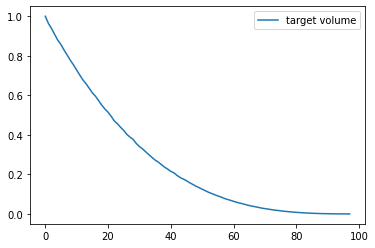

In [15]:
# iloc[row_selection, column_selection]
# can be used to separate between feature data and targets
# feature data: data we watn to learn from
# targets: desired outcome
sc = MinMaxScaler()
target_data = training_set['volume cm3']
df = pd.DataFrame({'volume cm3':target_data, 'euclidean distance': filtered_distance, 'x displacement': filtered_X_distance, 'y displacement':filtered_Y_distance})
training_data = sc.fit_transform(df)
target_data = training_data[:, 0]

if filteredInputs:
    feature_data = training_data[:, 1:]
    plt.plot( feature_data, label = 'feature data')
plt.plot( target_data, label = 'target volume')
plt.legend()
plt.show()

## Linear regression model

In [16]:
target_data_reshaped = np.array(target_data)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data_reshaped, test_size = 0.3, shuffle= True)

dataX = torch.Tensor(feature_data)
dataY = torch.Tensor(target_data_reshaped)

trainX = torch.Tensor(X_train)
trainY = torch.Tensor(y_train)

testX = torch.Tensor(X_test)
testY = torch.Tensor(y_test)

In [17]:
class LinearRegressionModel(torch.nn.Module): 
    def __init__(self, input_dim, output_dim): 
        super(LinearRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(input_dim, output_dim) 
    def forward(self, x): 
        y_pred = self.linear(x) 
        return y_pred 

In [18]:
learning_rate = 0.001
epochs = 150
output_size = 1
if featuresAreCoordinates:
    input_size = meanOfSensors*coordinates_depth
else:
    input_size = meanOfSensors*displacement_depth
if filteredInputs:
    input_size = displacement_depth
model = LinearRegressionModel(input_size, output_size)

In [19]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

## Train model

In [20]:
model.train()
for epoch in range(epochs): 
    # Forward pass: Compute predicted y by passing  
    # x to the model 
    output = model(trainX) 
    # Zero gradients, perform a backward pass,  
    optimizer.zero_grad()  
    # Compute and print loss 
    loss = criterion(output, trainY) 
  
    # update the weights. 
    loss.backward() 
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, MSE: %1.5f" % (epoch, loss.item()))
    if epoch == (epochs-1):
        print("MSE:  %1.5f, RMSE: %1.5f" % (loss.item(), math.sqrt(loss.item())))

Epoch: 0, MSE: 0.15733
Epoch: 100, MSE: 0.02286
MSE:  0.01397, RMSE: 0.11818


MSE:  0.04455, RMSE: 0.21107


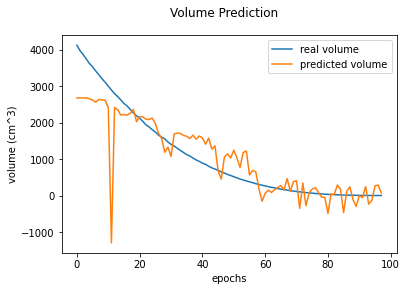

In [21]:
model.eval() # sets the model to evaluation mode
test_predict = model(testX)
real_loss = criterion(test_predict, testY)
print("MSE:  %1.5f, RMSE: %1.5f" % (real_loss.item(), math.sqrt(real_loss.item())))

train_predict = model(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()


# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(target_data), 4) )
# put the predicted values in the right field
trainPredict_dataset_like[:, 0] = data_predict[:,0]
# inverse transform and then select the right field
data_predict = sc.inverse_transform(trainPredict_dataset_like)[:,0]
trainPredict_dataset_like[:, 0] = dataY_plot[:,0]
dataY_plot = sc.inverse_transform(trainPredict_dataset_like)[:,0]

plt.plot(dataY_plot, label = "real volume")
plt.plot(data_predict, label = "predicted volume")
plt.suptitle('Volume Prediction')
plt.xlabel('epochs')
plt.ylabel('volume (cm^3)')
plt.legend()
plt.show()


In [19]:
#Saving a checkpoint
# torch.save(model.state_dict(), 'MODELS/BALL/ball-LinearRegression-SIFTDisplacement.pth')